### _Imports_

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import RobustScaler, StandardScaler

from sklearn.linear_model  import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pylab as plt

import functions as fn # importing pre-defined functions from .py file (inside notebooks folder)

### Upload diamonds train data from csv

In [2]:
diamonds_train = pd.read_csv('../data/diamonds_train.csv')
diamonds_train.head()

,price,carat,city,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,Dubai,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2
1,505,0.32,Kimberly,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2
2,2686,0.71,Las Vegas,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1
3,738,0.41,Kimberly,63.8,56.0,4.68,4.72,3.00,Good,D,SI1
4,4882,1.02,Dubai,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1


**Remark**: For the diamonds dataset, we have conducted an exploratory data analysis (EDA) in advance. Find references [here](https://github.com/Kristinawk/EDA_Diamonds).  
  
This dataset doesn't have nulls, therefore we can proceed directly with encoding.

## 1. Features selection and engineering

### Outliers

During EDA we saw that some diamonds have ceros in size parameters x, y and z. It would be better to take these rows out for machine learning.

In [3]:
len(diamonds_train.query('x == 0 or y == 0 or z == 0'))

16

In total, there are 16 rows with this issue. Lets drop these values.

In [4]:
diamonds_train.drop(diamonds_train.query('x == 0 or y == 0 or z == 0').index, inplace=True)

Now lets see the outliers in scatter plot

In [5]:
cat_var_lst = ["city", "cut", "color", "clarity"]
num_var_lst = ([i for i in list(diamonds_train.columns) if i not in cat_var_lst])

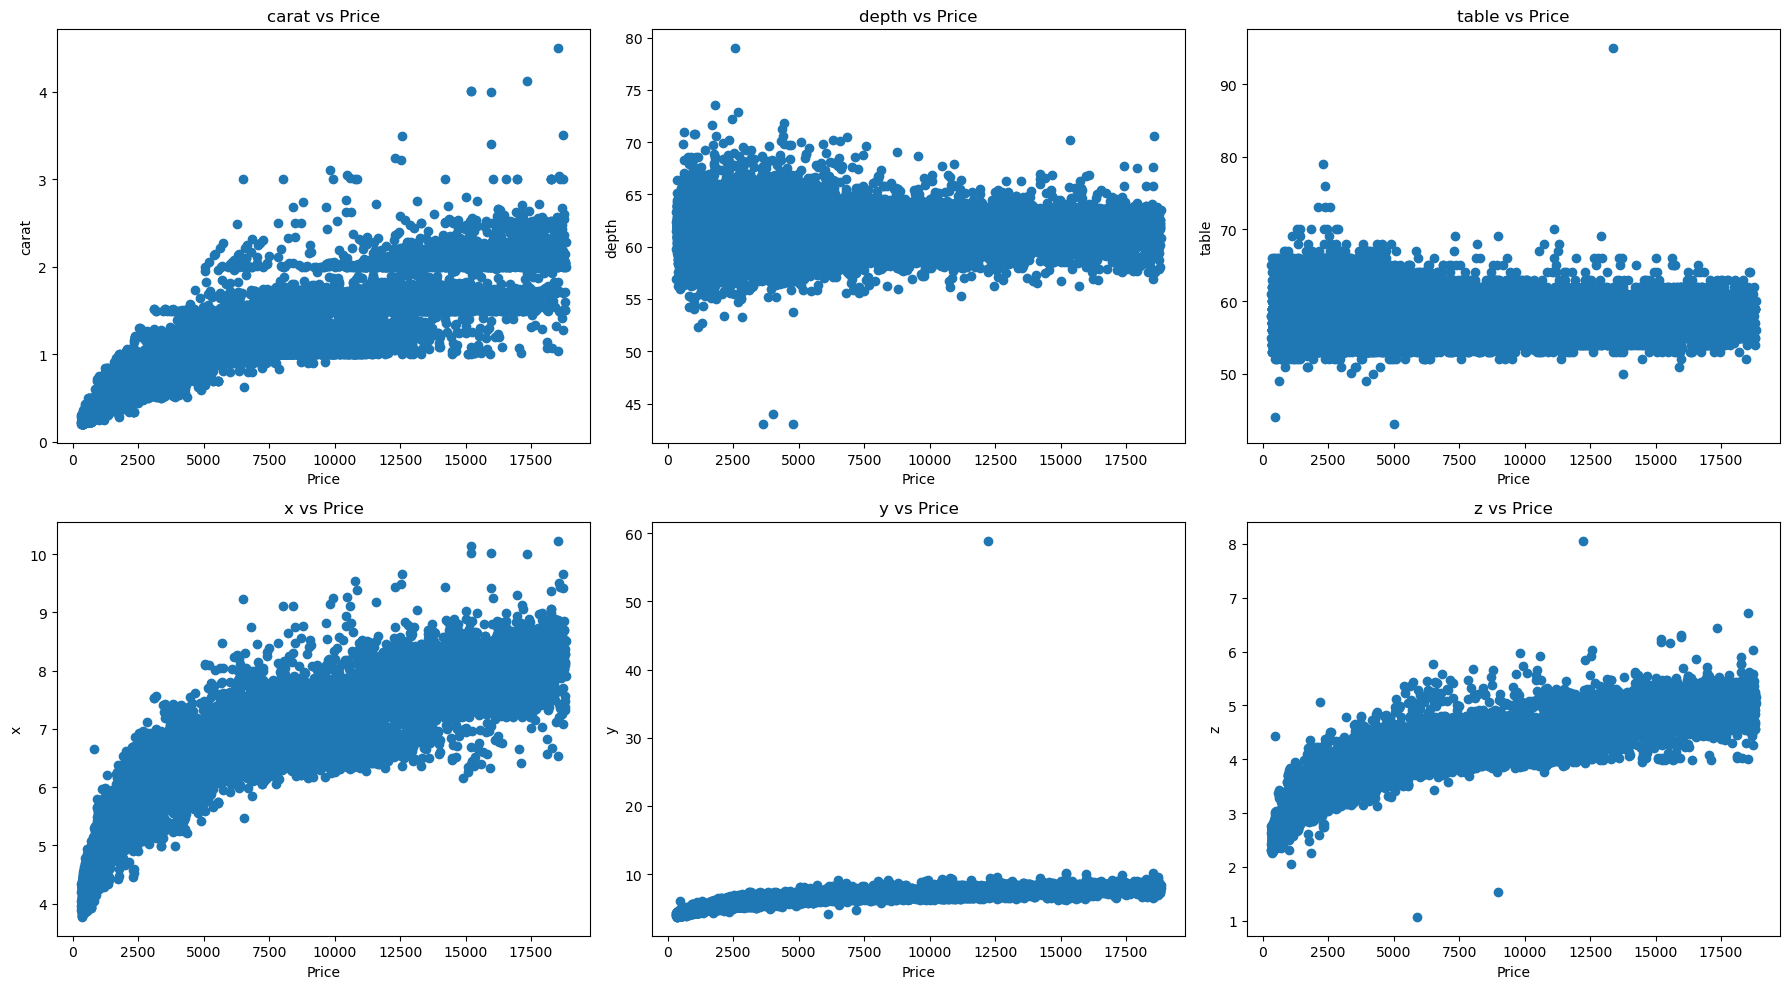

In [6]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Lets clean the dataset

In [7]:
len(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45'))

8

In [8]:
diamonds_train.drop(diamonds_train.query('x > 30 or y > 30 or z > 30 or z < 2 or table > 80 or table < 40 or depth > 75 or depth < 45').index, inplace=True)

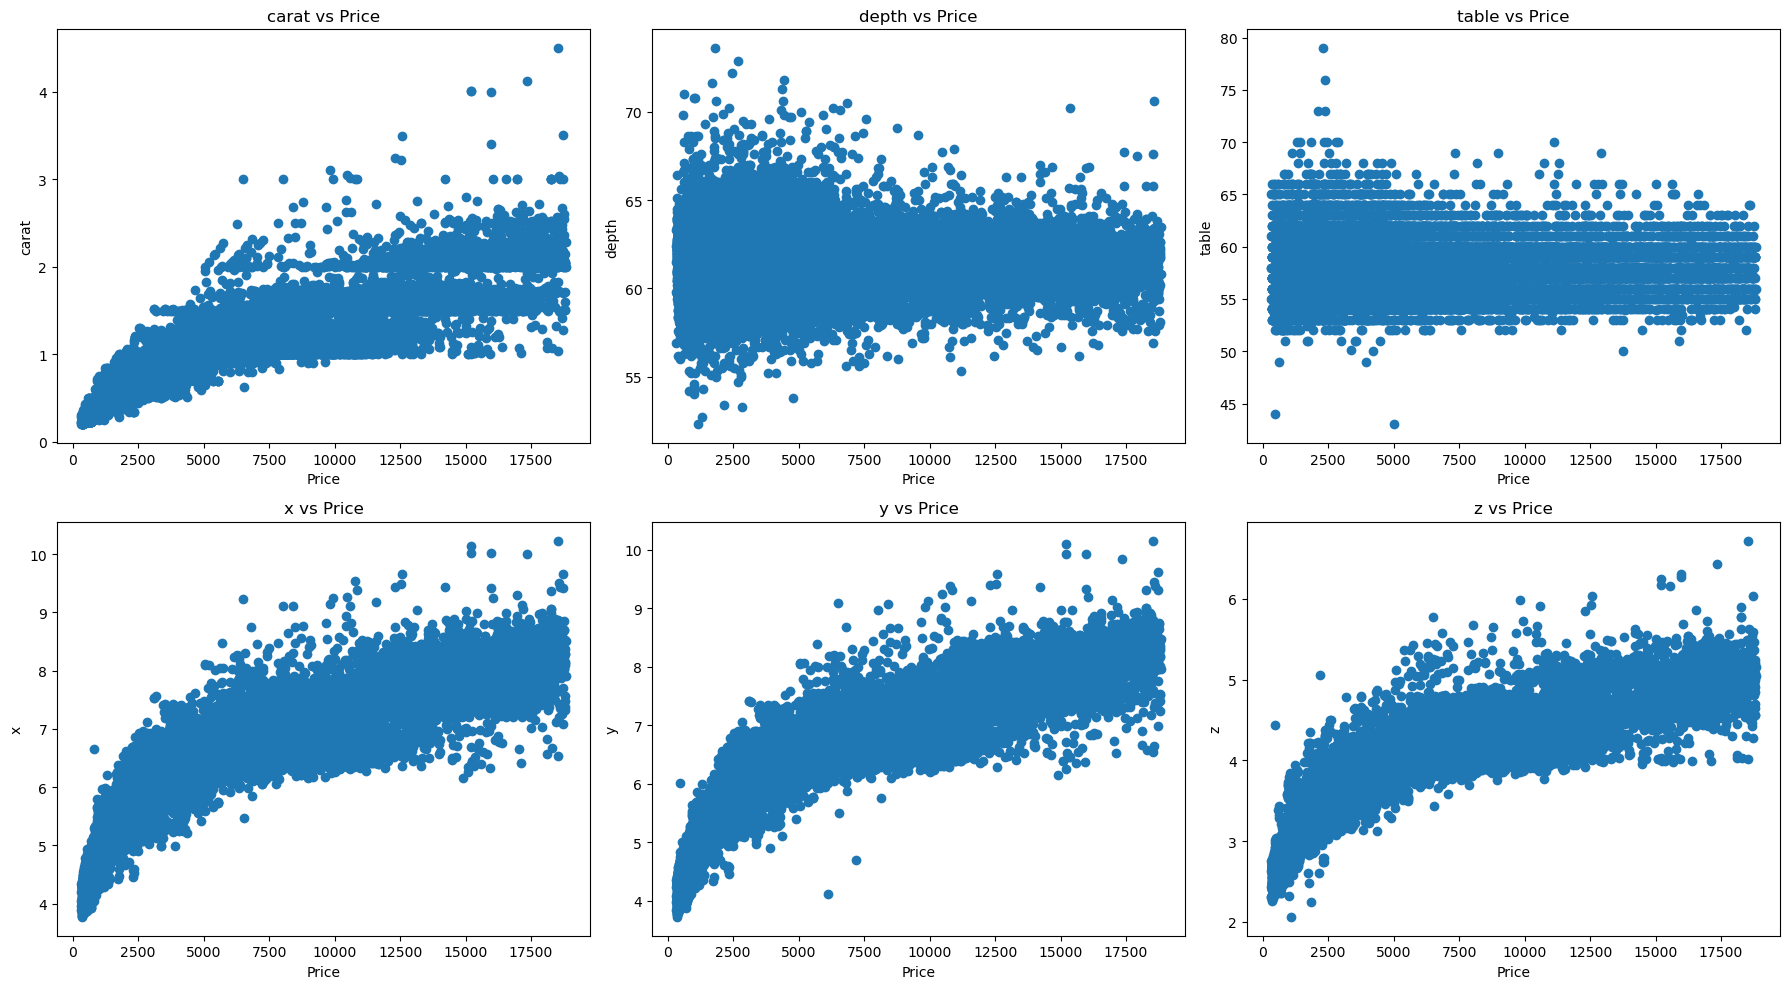

In [9]:
# Create a 2x3 grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Increase figsize for better spacing

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through the features and plot on the corresponding subplot
for i, feature in enumerate(num_var_lst[1:]):  # Adjust the range to match your desired features
    ax = axes[i]  # Access the subplot
    ax.scatter(diamonds_train['price'], diamonds_train[feature])  # Scatter plot on the current axis
    ax.set_xlabel('Price')
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} vs Price')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

The dataset seems cleaner now

## 2. Encoding

### Categorical variables overview

In [10]:
cat_var_lst = ["city", "cut", "color", "clarity"]
cat_var_overview = fn.cat_var(diamonds_train, cat_var_lst)
cat_var_overview

,categorical_variable,number_of_possible_values,values
0,city,13,"[Dubai, Kimberly, Las Vegas, Tel Aviv, Amsterd..."
1,clarity,8,"[VS2, VS1, SI1, SI2, IF, VVS1, VVS2, I1]"
2,color,7,"[J, H, G, D, F, E, I]"
3,cut,5,"[Premium, Very Good, Fair, Good, Ideal]"


### One hot encoding

In [11]:
# city:

#baseline_train = fn.one_hot_encod(diamonds_train, 'city')

baseline_train = diamonds_train.drop("city", axis=1)
baseline_train.head()

,price,carat,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2
1,505,0.32,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1
3,738,0.41,63.8,56.0,4.68,4.72,3.00,Good,D,SI1
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1


### Label encoding

In [12]:
# Apply label encoder to the rest of categorical variables:

label_encoder = LabelEncoder()
for col in ["cut", "color", "clarity"]:
    baseline_train[col] = label_encoder.fit_transform(baseline_train[col])
baseline_train.head()

,price,carat,depth,table,x,y,z,cut,color,clarity
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,3,6,5
1,505,0.32,63.0,57.0,4.35,4.38,2.75,4,4,5
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,0,3,4
3,738,0.41,63.8,56.0,4.68,4.72,3.00,1,0,2
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,2,3,2


## 3. Correlation matrix

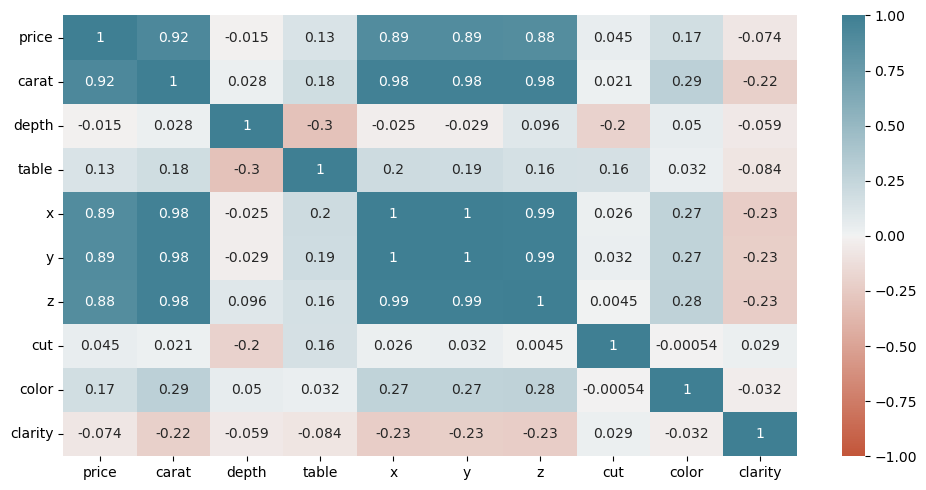

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(baseline_train.corr(),
                 vmin=-1,
                 vmax=1,
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax,
                 annot=True)
plt.tight_layout()

### Save pre-processing to csv

In [14]:
#baseline_train.to_csv('../data/baseline_train.csv', index=False)

## 3. Model selection

In [15]:
y0 = baseline_train['price'].astype('float64').to_numpy()
X0 = baseline_train[[col for col in baseline_train.columns if col != 'price']].to_numpy()

In [17]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.2, random_state = 42)
#print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
#print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

## 3. a) ElasticNet

In [13]:
model_elasticnet = ElasticNet()

fn.cross_val(model_elasticnet, X, y)

Cross val. scores: [-1833.64390701 -1937.89311616 -1838.94606472 -1834.4722746
 -1803.07991273] 

Mean of scores: 1849.6070550429442 



## 3. b) SVR

In [16]:
model_svr = SVR()

fn.cross_val(model_svr, X, y)

Cross val. scores: [-4208.27630307 -4349.59084525 -4258.49970513 -4225.98461454
 -4222.88255361] 

Mean of scores: 4253.046804323332 



## 3. c) Ridge

In [17]:
model_ridge = Ridge()

fn.cross_val(model_ridge, X, y)

Cross val. scores: [-1162.37097317 -1236.84771998 -1181.36659532 -1123.77678443
 -1086.81019334] 

Mean of scores: 1158.2344532457496 



## 3. d) Decision Tree Regressor

In [20]:
model_decisiontree = DecisionTreeRegressor()

fn.cross_val(model_decisiontree, X, y)

Cross val. scores: [-877.62931559 -872.70115246 -907.36536323 -858.23774212 -845.13098535] 

Mean of scores: 872.2129117503431 



## 3. e) RandomForestRegressor

In [48]:
model_randomforest = RandomForestRegressor()

fn.cross_val(model_randomforest, X, y)

Cross val. scores: [-654.95224026 -662.57559913 -670.01148258 -665.67893135 -651.56808185] 

Mean of scores: 660.9572670347252 



## 3. f) GradientBoostingRegressor

In [23]:
model_gradientboosting = GradientBoostingRegressor()

fn.cross_val(model_gradientboosting, X, y)

Cross val. scores: [-879.59064277 -856.04185565 -889.98164808 -869.74512933 -827.06412632] 

Mean of scores: 864.484680430803 



## 3. g) ExtraTreesRegressor

In [26]:
model_extratrees = ExtraTreesRegressor()

fn.cross_val(model_extratrees, X, y)

Cross val. scores: [-613.81259552 -619.0077115  -614.08969898 -620.04012503 -598.93489935] 

Mean of scores: 613.1770060765838 



## 3. h) BaggingRegressor

In [28]:
model_bagging = BaggingRegressor()

fn.cross_val(model_bagging, X, y)

Cross val. scores: [-691.21925102 -708.19306603 -713.79584737 -700.17574779 -678.97964718] 

Mean of scores: 698.4727118796867 



## 3. i) StackingRegressor

In [18]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X0)

In [20]:
scaled_data_train.shape

(40431, 9)

In [21]:
X1_train, X1_test, y1_train, y1_test = train_test_split(scaled_data_train, y0, test_size = 0.2, random_state = 42)

In [22]:
# Define base models
base_learners = [
    ('rf', RandomForestRegressor(n_estimators=200, 
                                 max_depth=None,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 max_features=None)),
    ('lr', ExtraTreesRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=6,
                                min_samples_leaf=2,
                                max_features=None))
]

# Define meta-model (Ridge regression)
meta_model = Ridge()


#    ('gb', GradientBoostingRegressor(n_estimators=100)),

In [23]:
# Create the Stacking Regressor
stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_model)

In [24]:
#fn.cross_val(stacking_regressor, X1, y0)

## 3. j) AdaBoostRegressor

In [31]:
model_adaboost = AdaBoostRegressor()

fn.cross_val(model_adaboost, X, y)

Cross val. scores: [-1599.44833947 -1511.38562057 -1520.56161739 -1555.29603015
 -1547.01533228] 

Mean of scores: 1546.7413879698531 



**CONCLUSION**: Stacking Regressor provides the best metrics: RMSE 606 in test dataset and 603 in Kaggle.

### Grid Search: RandomForestRegressor

In [45]:
param_grid = {'n_estimators': [100, 200, 300],  # Number of trees in the forest.
              'max_depth': [None, 3, 10],  # Maximum depth of the trees.
              'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split.
              }

In [49]:
grid_search = GridSearchCV(model_randomforest,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [50]:
grid_search.fit(X, y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} 

Best score:  659.2117645213639 



### Grid Search: ExtraTreesRegressor

In [62]:
param_grid = {'n_estimators': [100],  # Number of trees in the forest.
              'max_depth': [None],  # Maximum depth of the trees.
              'min_samples_split': [6],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [2],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None]  # Number of features to consider when looking for the best split.
              }

In [63]:
grid_search = GridSearchCV(model_extratrees,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [64]:
grid_search.fit(X, y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Best hyperparameters:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100} 

Best score:  606.4497365477694 



### Fit Model

In [25]:
stacking_regressor.fit(X1_train, y1_train)
y1_pred = stacking_regressor.predict(X1_test)

### Visual check

In [26]:
check = pd.DataFrame({'Ground truth': y1_test, 'Predictions': y1_pred, 'Diff': y1_test - y1_pred})
check

,Ground truth,Predictions,Diff
0,2217.0,2179.499264,37.500736
1,1798.0,1771.896901,26.103099
2,13445.0,16443.526245,-2998.526245
3,8044.0,8251.317349,-207.317349
4,810.0,701.103715,108.896285
...,...,...,...
8082,1130.0,947.806923,182.193077
8083,6776.0,6494.416356,281.583644
8084,788.0,773.093905,14.906095
8085,2283.0,2357.922588,-74.922588


In [27]:
check.reset_index(inplace=True)

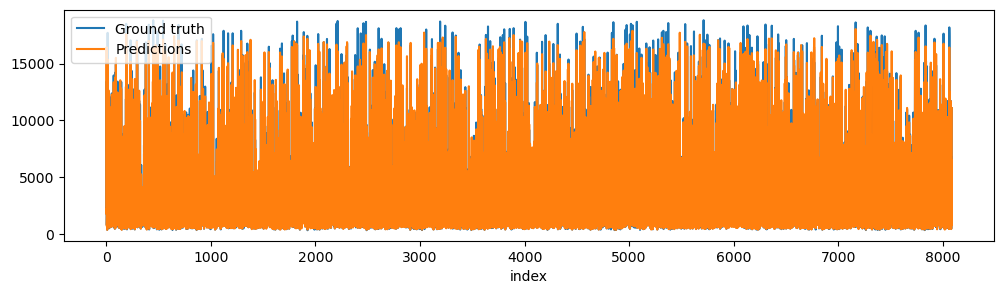

In [28]:
check.plot(x='index', y=['Ground truth', 'Predictions'], kind='line', figsize=(12, 3));

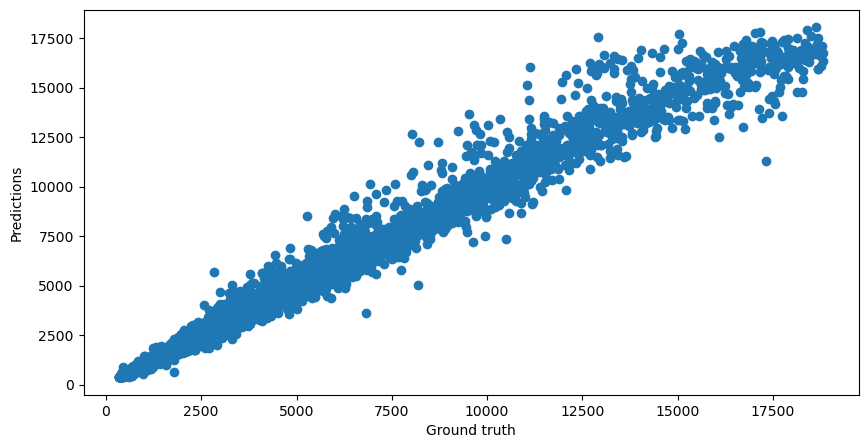

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.scatter(y1_test, y1_pred)
ax.set_xlabel('Ground truth')
ax.set_ylabel('Predictions')
#ax.set_title('')
plt.show()

# 4. Predictions

### Upload diamonds test data from csv

In [30]:
diamonds_test = pd.read_csv('../data/diamonds_test.csv')
#diamonds_test.head()

### Encoding

In [31]:
baseline_test = diamonds_test.drop(["city", "id"], axis=1)

In [32]:
label_encoder = LabelEncoder()
for col in ["cut", "color", "clarity"]:
    baseline_test[col] = label_encoder.fit_transform(baseline_test[col])
baseline_test.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,4,2,2,62.7,60.0,5.82,5.89,3.67
1,1.20,2,6,4,61.0,57.0,6.81,6.89,4.18
2,1.57,3,4,2,62.2,61.0,7.38,7.32,4.57
3,0.90,4,2,2,63.8,54.0,6.09,6.13,3.90
4,0.50,4,2,4,62.9,58.0,5.05,5.09,3.19


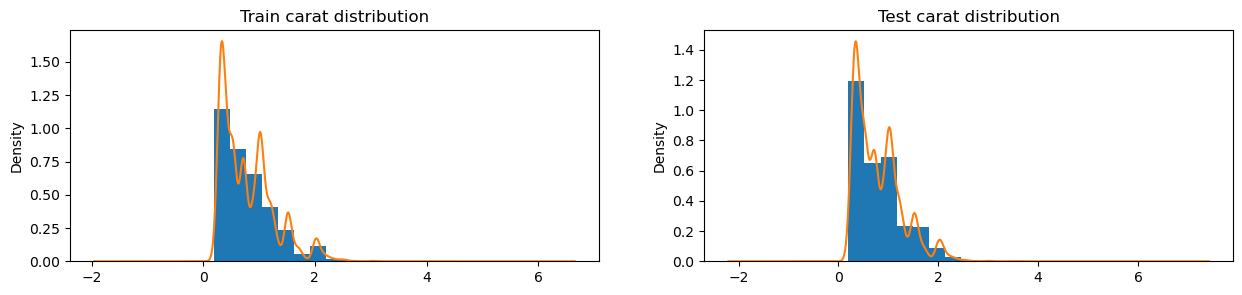

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['carat'], density=True, bins=15)
baseline_train['carat'].plot.density(ax=axes[0])
axes[0].set_title('Train carat distribution')

axes[1].hist(baseline_test['carat'], density=True, bins=15)
baseline_test['carat'].plot.density(ax=axes[1])
axes[1].set_title('Test carat distribution')

plt.show()

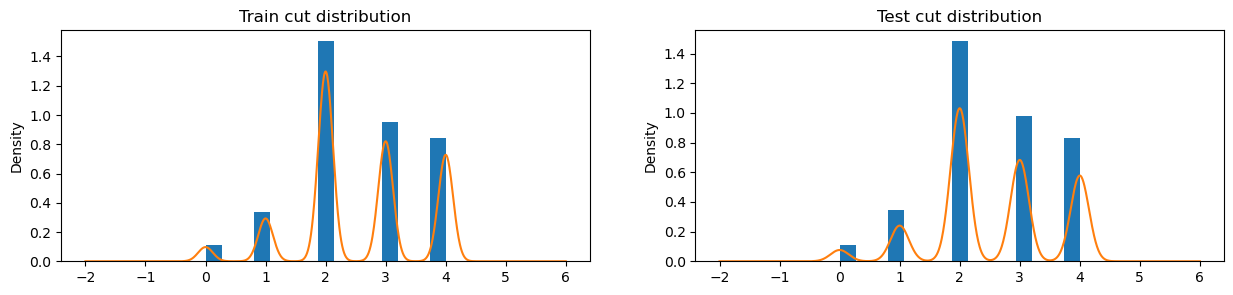

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['cut'], density=True, bins=15)
baseline_train['cut'].plot.density(ax=axes[0])
axes[0].set_title('Train cut distribution')

axes[1].hist(baseline_test['cut'], density=True, bins=15)
baseline_test['cut'].plot.density(ax=axes[1])
axes[1].set_title('Test cut distribution')

plt.show()

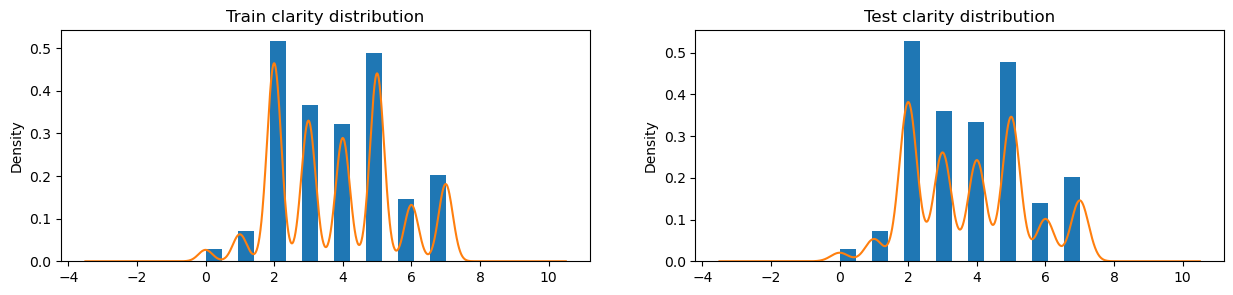

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['clarity'], density=True, bins=15)
baseline_train['clarity'].plot.density(ax=axes[0])
axes[0].set_title('Train clarity distribution')

axes[1].hist(baseline_test['clarity'], density=True, bins=15)
baseline_test['clarity'].plot.density(ax=axes[1])
axes[1].set_title('Test clarity distribution')

plt.show()

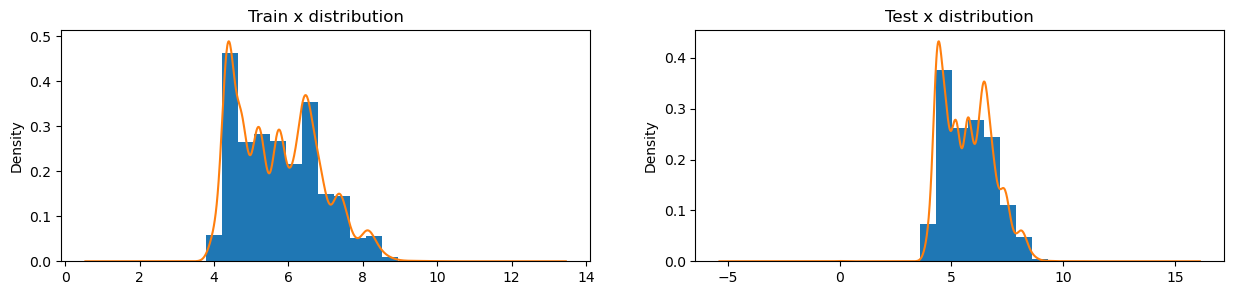

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['x'], density=True, bins=15)
baseline_train['x'].plot.density(ax=axes[0])
axes[0].set_title('Train x distribution')

axes[1].hist(baseline_test['x'], density=True, bins=15)
baseline_test['x'].plot.density(ax=axes[1])
axes[1].set_title('Test x distribution')

plt.show()

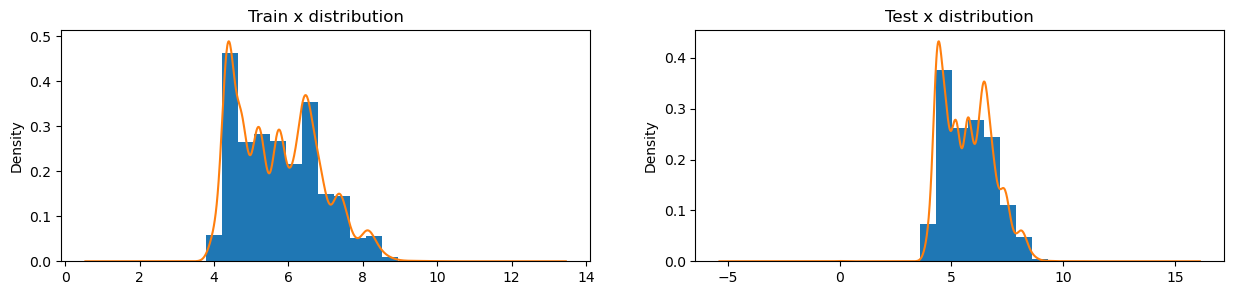

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['x'], density=True, bins=15)
baseline_train['x'].plot.density(ax=axes[0])
axes[0].set_title('Train x distribution')

axes[1].hist(baseline_test['x'], density=True, bins=15)
baseline_test['x'].plot.density(ax=axes[1])
axes[1].set_title('Test x distribution')

plt.show()

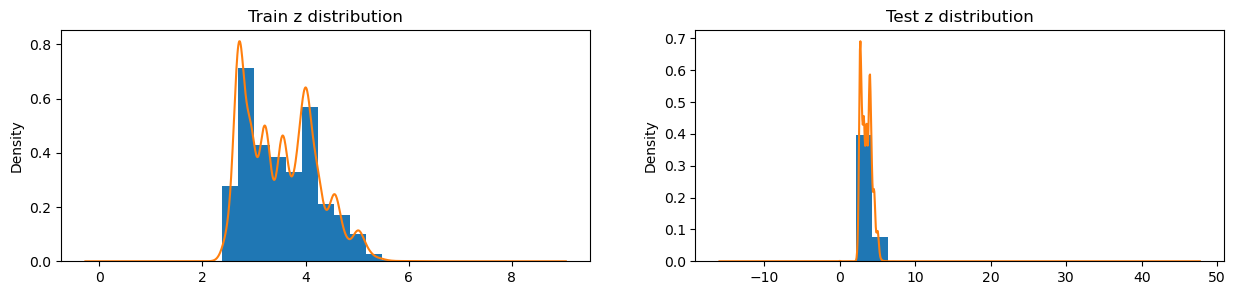

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].hist(baseline_train['z'], density=True, bins=15)
baseline_train['z'].plot.density(ax=axes[0])
axes[0].set_title('Train z distribution')

axes[1].hist(baseline_test['z'], density=True, bins=15)
baseline_test['z'].plot.density(ax=axes[1])
axes[1].set_title('Test z distribution')

plt.show()

### Scalling

In [39]:
scaler = StandardScaler()
scaled_data_test = scaler.fit_transform(baseline_test)

In [40]:
scaled_data_test

array([[-0.01841187,  1.41126057, -0.34052962, ...,  0.07502152,
         0.13323602,  0.17309121],
       [ 0.85507765, -0.54122212,  2.0116496 , ...,  0.96400677,
         1.01939517,  0.87078717],
       [ 1.64334867,  0.43501923,  0.83555999, ...,  1.47584677,
         1.40044361,  1.40431938],
       ...,
       [-0.21015347, -0.54122212, -0.34052962, ...,  0.01216398,
        -0.02627263, -0.01843317],
       [-0.21015347,  1.41126057, -0.34052962, ...,  0.10196047,
         0.13323602, -0.12787567],
       [-0.84929214, -0.54122212,  1.4236048 , ..., -0.93069917,
        -0.89470861, -0.82557163]], shape=(13485, 9))

### Predict: StackingRegressor

In [41]:
stacking_regressor_pred = stacking_regressor.predict(scaled_data_test)

In [42]:
stacking_regressor_pred

array([4692.94830523, 3885.83940746, 5389.80961793, ..., 2343.78377315,
       1871.29488141, 3298.09651199], shape=(13485,))

### Save

In [97]:
fn.save_pred(diamonds_test, stacking_regressor_pred, 'encod03_featu00_model01')

'file saved succesfully'